In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2014, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,400548974,2014,1,regular,True,False,3906.0,331,Eastern Washington,Big Sky,fcs,56.0,NaN,2534,Sam Houston,Southland,fcs,35.0,NaN
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,38.0,NaN,2000,Abilene Christian,Southland,fcs,37.0,NaN
2,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,28.0,1863.0,245,Texas A&M,SEC,fbs,52.0,1765.0
3,400547829,2014,1,regular,True,False,3817.0,2433,UL Monroe,Sun Belt,fbs,17.0,1304.0,154,Wake Forest,ACC,fbs,10.0,1377.0
4,400557394,2014,1,regular,True,False,3658.0,2127,Charleston Southern,Big South,fcs,61.0,NaN,3179,Point University,None,None,9.0,NaN


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Fetching 2024 weather data from CFBD API


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,400610221,2014,1,postseason,2014-12-20 20:30:00+00:00,False,Colorado State,Mountain West,Utah,Pac-12,3914,Sam Boyd Stadium,53.6,43.0,67.0,0.0,0,180.0,0.0,1022.5,NaN,None
1,400610199,2014,1,postseason,2014-12-24 02:30:00+00:00,False,San Diego State,Mountain West,Navy,FBS Independents,3932,Qualcomm Stadium,68.0,54.1,61.0,0.0,0,100.0,0.0,1017.5,NaN,None
2,400548409,2014,2,regular,2014-09-06 18:00:00+00:00,False,Georgia State,Sun Belt,New Mexico State,Sun Belt,3495,Georgia Dome,87.1,66.7,51.0,0.0,0,360.0,0.0,1015.3,NaN,None
3,400548252,2014,14,regular,2014-11-30 03:30:00+00:00,False,UNLV,Mountain West,Nevada,Mountain West,3914,Sam Boyd Stadium,64.4,21.2,19.0,0.0,0,220.0,0.0,1008.5,NaN,None
4,400609076,2014,15,regular,2014-12-06 02:20:00+00:00,False,Oregon,Pac-12,Arizona,Pac-12,4738,Levi's Stadium,62.1,57.7,86.0,0.0,0,180.0,0.0,1016.3,NaN,None


In [6]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [7]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,Temple,American Athletic,Vanderbilt,SEC,400547640,4005476401,1,False,1,35,35,1,63,63,6,18,PUNT,False,0,0,0,0,15,0,12,7
1,Vanderbilt,SEC,Temple,American Athletic,400547640,4005476402,2,False,1,28,72,1,31,69,3,3,PUNT,True,0,0,0,0,12,7,10,4
2,Temple,American Athletic,Vanderbilt,SEC,400547640,4005476403,3,False,1,73,73,1,64,64,3,9,PUNT,False,0,0,0,0,10,4,8,26
3,Vanderbilt,SEC,Temple,American Athletic,400547640,4005476404,4,False,1,21,79,1,25,75,3,4,PUNT,True,0,0,0,0,8,26,6,44
4,Temple,American Athletic,Vanderbilt,SEC,400547640,4005476405,5,False,1,64,64,1,75,75,3,-11,PUNT,False,0,0,0,0,6,44,5,36


In [8]:
fg_events = [c for c in df_drives.drive_result.unique() if 'FG' in c]
print(fg_events)
df_drives = df_drives[df_drives.drive_result.isin(fg_events)].reset_index(drop=True)

['MISSED FG', 'FG', 'FG TD', 'MISSED FG TD', 'FG MISSED', 'FG GOOD', 'BLOCKED FG']


In [9]:
df_drives.columns

Index(['offense', 'offense_conference', 'defense', 'defense_conference',
       'game_id', 'id', 'drive_number', 'scoring', 'start_period',
       'start_yardline', 'start_yards_to_goal', 'end_period', 'end_yardline',
       'end_yards_to_goal', 'plays', 'yards', 'drive_result',
       'is_home_offense', 'start_offense_score', 'start_defense_score',
       'end_offense_score', 'end_defense_score', 'start_time_minutes',
       'start_time_seconds', 'end_time_minutes', 'end_time_seconds'],
      dtype='object')

## 2. Join and Filter the Data

In [10]:
df_weather.head()

,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,400610221,2014,1,postseason,2014-12-20 20:30:00+00:00,False,Colorado State,Mountain West,Utah,Pac-12,3914,Sam Boyd Stadium,53.6,43.0,67.0,0.0,0,180.0,0.0,1022.5,NaN,None
1,400610199,2014,1,postseason,2014-12-24 02:30:00+00:00,False,San Diego State,Mountain West,Navy,FBS Independents,3932,Qualcomm Stadium,68.0,54.1,61.0,0.0,0,100.0,0.0,1017.5,NaN,None
2,400548409,2014,2,regular,2014-09-06 18:00:00+00:00,False,Georgia State,Sun Belt,New Mexico State,Sun Belt,3495,Georgia Dome,87.1,66.7,51.0,0.0,0,360.0,0.0,1015.3,NaN,None
3,400548252,2014,14,regular,2014-11-30 03:30:00+00:00,False,UNLV,Mountain West,Nevada,Mountain West,3914,Sam Boyd Stadium,64.4,21.2,19.0,0.0,0,220.0,0.0,1008.5,NaN,None
4,400609076,2014,15,regular,2014-12-06 02:20:00+00:00,False,Oregon,Pac-12,Arizona,Pac-12,4738,Levi's Stadium,62.1,57.7,86.0,0.0,0,180.0,0.0,1016.3,NaN,None


In [11]:
df_venues.head()

,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [12]:
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
    'away_id', 'away_team','away_conference', 'away_division']
drive_cols = ['offense', 'defense',
       'game_id', 'id', 'drive_number',
       'end_yards_to_goal', 'drive_result',
       'is_home_offense', 'start_offense_score', 'end_offense_score', 'end_defense_score',
       'end_period', 'end_time_minutes', 'end_time_seconds']
weather_cols = ['id', 'game_indoors', 'temperature', 'dew_point', 'humidity',
       'precipitation', 'snowfall', 'wind_speed', 'pressure', 'weather_condition']
venue_cols = ['id', 'elevation', 'grass']

df = (
    df_games[game_cols].rename(columns={'id': 'game_id'})
    .merge(
        (
            df_drives
            [drive_cols]
            .rename(columns={'id': 'drive_id'})
        ),
        on=['game_id'],
        how='left',
    )
    .dropna(subset=['drive_id'])
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id': 'venue_id'}),
        on=['venue_id'],
        how='left',
    )
)

In [13]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,end_yards_to_goal,drive_result,is_home_offense,start_offense_score,end_offense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass
0,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484031,1.0,8.0,FG,False,0.0,3.0,0.0,1.0,8.0,58.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484037,7.0,25.0,FG,False,3.0,6.0,14.0,2.0,7.0,31.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False
2,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840311,11.0,16.0,FG,False,13.0,16.0,14.0,2.0,1.0,11.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.1637268,False
3,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,Texas A&M,South Carolina,4005484023,3.0,15.0,FG,False,7.0,10.0,0.0,1.0,5.0,2.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.54548645,True
4,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,South Carolina,Texas A&M,40054840212,12.0,36.0,MISSED FG,True,14.0,14.0,31.0,2.0,0.0,5.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.54548645,True


In [14]:
df.drive_result.value_counts()

drive_result
FG              23963
MISSED FG        8450
MISSED FG TD       59
BLOCKED FG         10
FG TD               7
FG GOOD             7
FG MISSED           3
Name: count, dtype: int64

In [15]:
df.isna().sum()

game_id                    0
season                     0
week                       0
season_type                0
completed                  0
neutral_site               0
venue_id                   0
home_id                    0
home_team                  0
home_conference            0
home_division              0
away_id                    0
away_team                  0
away_conference           87
away_division             87
offense                    0
defense                    0
drive_id                   0
drive_number               0
end_yards_to_goal          0
drive_result               0
is_home_offense            0
start_offense_score        0
end_offense_score          0
end_defense_score          0
end_period                 0
end_time_minutes           0
end_time_seconds           0
game_indoors             632
temperature              632
dew_point                632
humidity                 632
precipitation            632
snowfall                 632
wind_speed    

## 3. Feature Engineering

In [16]:
df = df.assign(
    pct_game_played = (((df['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))) / (4 * 15 * 60),
    score_diff = df['end_offense_score'] - df['end_defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home_team], [0, 1], default=-1),
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    off_pts_scored = df.end_offense_score - df.start_offense_score,
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
)

df['elevation'] = df['elevation'].astype(float)

df['fg_made'] = np.where(df.off_pts_scored == 3, 1, 0)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34590/146011989.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34590/146011989.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


In [17]:
df.is_home_team.value_counts()

is_home_team
 1    15594
-1    14696
 0     2209
Name: count, dtype: int64

In [18]:
# Filter out overtime plays
df = df.query('0 < end_period <= 4')

# Game must be completed
df = df.query('completed == True')

# Filter out FG attempts where offense scored other than 0 or 3 points
df = df.query('off_pts_scored.isin([0,3])')

df.rename(columns={'end_yards_to_goal': 'fg_distance'}, inplace=True)

# Assuming any FG attempts over 60 yards is an erroneous datapoint
df = df.query('fg_distance <= 60').reset_index(drop=True)

df = df.query('0 <= pct_game_played <= 1')

df.reset_index(drop=True, inplace=True)

In [19]:
df[['fg_made','drive_result']].value_counts()

fg_made  drive_result
1        FG              22679
0        MISSED FG        8126
         FG                372
         MISSED FG TD       56
         BLOCKED FG         10
1        FG GOOD             5
         FG TD               4
0        FG MISSED           2
         FG TD               2
1        MISSED FG           2
Name: count, dtype: int64

## 4. Final Data

In [20]:
# at least one team in fbs
df = df.query('offense_division == "fbs" or defense_division == "fbs"').reset_index(drop=True)
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,fg_distance,drive_result,is_home_offense,start_offense_score,end_offense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,pct_game_played,score_diff,is_home_team,offense_division,defense_division,off_pts_scored,fg_made
0,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484031,1.0,8.0,FG,False,0.0,3.0,0.0,1.0,8.0,58.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,0.100556,3.0,0,fcs,fbs,3.0,1
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484037,7.0,25.0,FG,False,3.0,6.0,14.0,2.0,7.0,31.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,0.374722,-8.0,0,fcs,fbs,3.0,1
2,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840311,11.0,16.0,FG,False,13.0,16.0,14.0,2.0,1.0,11.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,0.480278,2.0,0,fcs,fbs,3.0,1
3,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,Texas A&M,South Carolina,4005484023,3.0,15.0,FG,False,7.0,10.0,0.0,1.0,5.0,2.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.545486,True,0.166111,10.0,-1,fbs,fbs,3.0,1
4,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,South Carolina,Texas A&M,40054840212,12.0,36.0,MISSED FG,True,14.0,14.0,31.0,2.0,0.0,5.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.545486,True,0.498611,-17.0,1,fbs,fbs,0.0,0


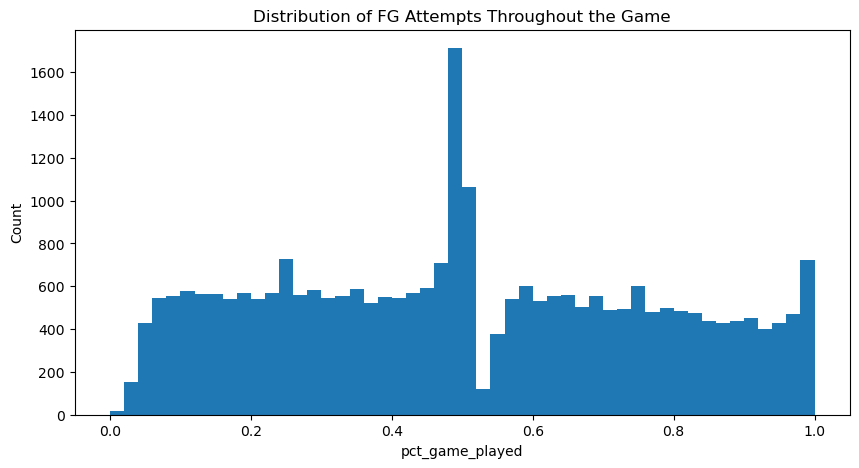

In [21]:
# plot a hist plot of pct_game_played
plt.figure(figsize=(10, 5))
plt.hist(df.pct_game_played, bins=50)
plt.title('Distribution of FG Attempts Throughout the Game')
plt.xlabel('pct_game_played')
plt.ylabel('Count')
plt.show()

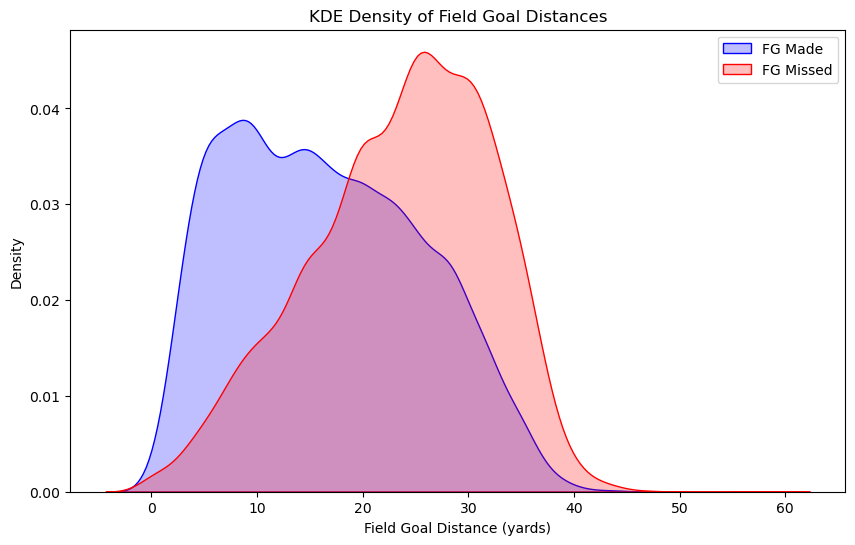

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df.query('fg_made==1').fg_distance, fill=True, color='blue', label='FG Made')
sns.kdeplot(df.query('fg_made==0').fg_distance, fill=True, color='red', label='FG Missed')
plt.title('KDE Density of Field Goal Distances')
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Density')
plt.legend()
plt.show()

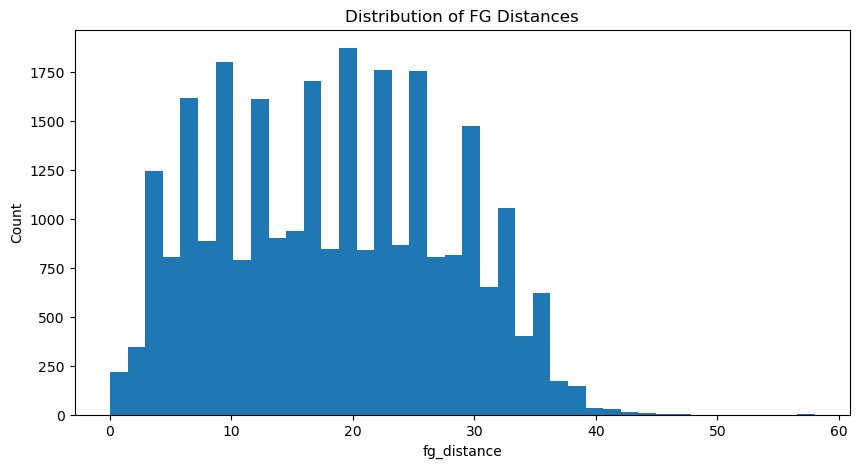

In [23]:
# plot a hist plot of fg_distance
plt.figure(figsize=(10, 5))
plt.hist(df.fg_distance, bins=40)
plt.title('Distribution of FG Distances')
plt.xlabel('fg_distance')
plt.ylabel('Count')
plt.show()

In [24]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,fg_distance,drive_result,is_home_offense,start_offense_score,end_offense_score,end_defense_score,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,pct_game_played,score_diff,is_home_team,offense_division,defense_division,off_pts_scored,fg_made
0,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484031,1.0,8.0,FG,False,0.0,3.0,0.0,1.0,8.0,58.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,0.100556,3.0,0,fcs,fbs,3.0,1
1,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,4005484037,7.0,25.0,FG,False,3.0,6.0,14.0,2.0,7.0,31.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,0.374722,-8.0,0,fcs,fbs,3.0,1
2,400548403,2014,1,regular,True,True,3495.0,2247,Georgia State,Sun Belt,fbs,2000,Abilene Christian,Southland,fcs,Abilene Christian,Georgia State,40054840311,11.0,16.0,FG,False,13.0,16.0,14.0,2.0,1.0,11.0,False,86.0,56.7,37.0,0.0,0.0,8.1,1015.5,None,303.163727,False,0.480278,2.0,0,fcs,fbs,3.0,1
3,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,Texas A&M,South Carolina,4005484023,3.0,15.0,FG,False,7.0,10.0,0.0,1.0,5.0,2.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.545486,True,0.166111,10.0,-1,fbs,fbs,3.0,1
4,400548402,2014,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,245,Texas A&M,SEC,fbs,South Carolina,Texas A&M,40054840212,12.0,36.0,MISSED FG,True,14.0,14.0,31.0,2.0,0.0,5.0,False,95.0,52.5,24.0,0.0,0.0,0.0,1014.4,None,60.545486,True,0.498611,-17.0,1,fbs,fbs,0.0,0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34590/3637822262.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


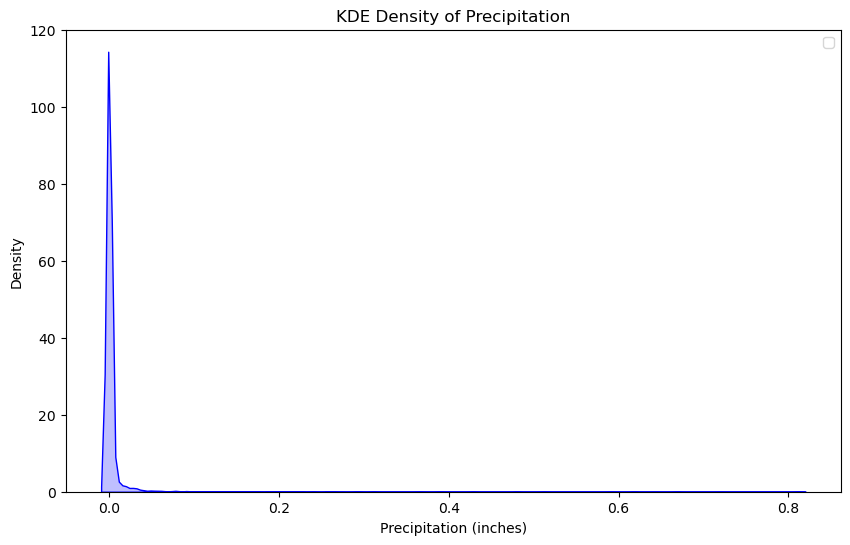

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df.precipitation, fill=True, color='blue')
plt.title('KDE Density of Precipitation')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34590/2083828262.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


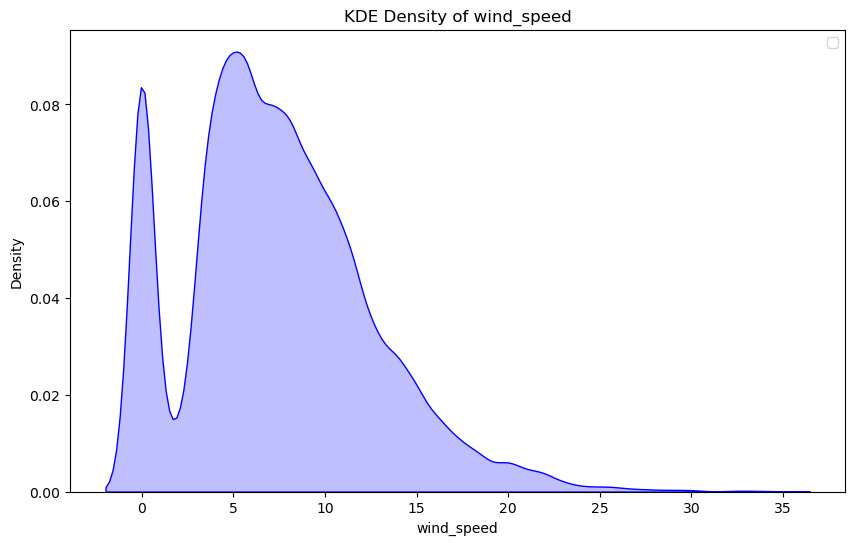

In [26]:
feature = 'wind_speed'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[feature], fill=True, color='blue')
plt.title(f'KDE Density of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_34590/829338877.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


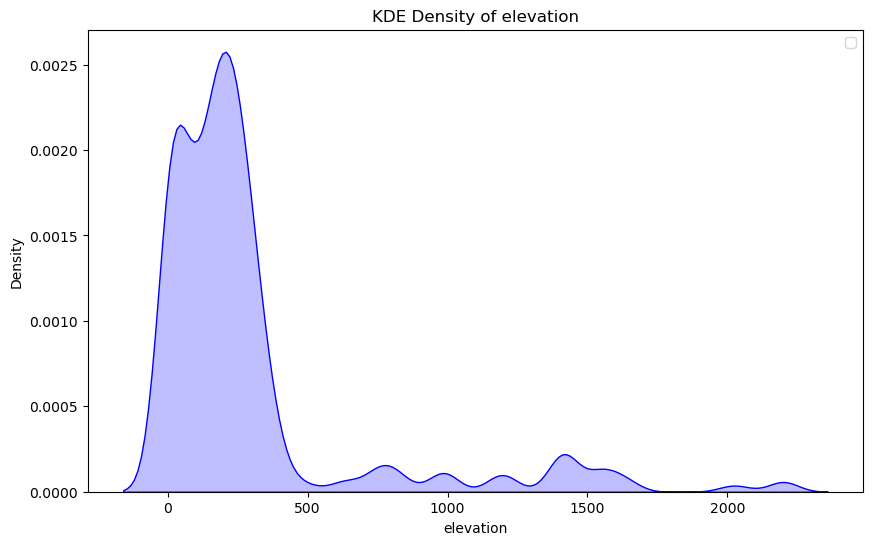

In [27]:
feature = 'elevation'
plt.figure(figsize=(10, 6))
sns.kdeplot(df[feature], fill=True, color='blue')
plt.title(f'KDE Density of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.legend()
plt.show()

## 5. Make the model

In [28]:
data = df[['game_id', 'fg_distance', 'pct_game_played', 'score_diff', 'is_home_team', 
           'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors']]
target = df[['fg_made']]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
target_train = target[target.index.isin(data_train.index)]

data_test = data[data.game_id.isin(game_ids_test)].drop(columns='game_id')
target_test = target[target.index.isin(data_test.index)]

In [29]:
data.head()

,game_id,fg_distance,pct_game_played,score_diff,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors
0,400548403,8.0,0.100556,3.0,0,False,303.163727,8.1,0.0,86.0,False
1,400548403,25.0,0.374722,-8.0,0,False,303.163727,8.1,0.0,86.0,False
2,400548403,16.0,0.480278,2.0,0,False,303.163727,8.1,0.0,86.0,False
3,400548402,15.0,0.166111,10.0,-1,True,60.545486,0.0,0.0,95.0,False
4,400548402,36.0,0.498611,-17.0,1,True,60.545486,0.0,0.0,95.0,False


In [30]:
data.isna().sum()

game_id            0
fg_distance        0
pct_game_played    0
score_diff         0
is_home_team       0
grass              0
elevation          0
wind_speed         0
precipitation      0
temperature        0
game_indoors       0
dtype: int64

In [161]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    game_ids = data_train.game_id.unique()
    game_ids_train, game_ids_valid = train_test_split(game_ids, test_size=0.2, random_state=42)
  
    train_x = data_train[data_train.game_id.isin(game_ids_train)].drop(columns='game_id')
    valid_x = data_train[data_train.game_id.isin(game_ids_valid)].drop(columns='game_id')
    train_y = target_train[target_train.index.isin(train_x.index)].values.ravel()
    valid_y = target_train[target_train.index.isin(valid_x.index)].values.ravel()
  
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    feature_names = train_x.columns.tolist()
    monotonic_constraints_map = {
        "fg_distance": -1,
        "wind_speed": -1,
        "elevation": 1,
        "is_home_team": 1,
        "precipitation": -1,
        "game_indoors": 1,
    }
    monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])
  
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "interaction_constraints": [["score_diff", "pct_game_played"]],
        "monotone_constraints": monotonic_constraints,
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.01, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return log_loss(valid_y, preds)

storage = "sqlite:///studies/fg_hyperopt.db"
study = optuna.create_study(
    study_name="fg_probability_hyperopt", 
    storage=storage, 
    direction="minimize", 
    load_if_exists=True
)
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)
print("Best value:", study.best_value)

[I 2025-03-30 14:50:03,549] A new study created in RDB with name: fg_probability_hyperopt
[I 2025-03-30 14:50:04,502] Trial 0 finished with value: 0.40653776234020167 and parameters: {'lambda': 1.0796724093333816, 'alpha': 7.774117978429834, 'eta': 0.04, 'max_depth': 9, 'min_child_weight': 9.0, 'gamma': 0.004019450778656114, 'grow_policy': 'lossguide', 'subsample': 0.91485650027113, 'colsample_bytree': 0.7939504983035695}. Best is trial 0 with value: 0.40653776234020167.
[I 2025-03-30 14:50:04,675] Trial 1 finished with value: 0.39801518242673967 and parameters: {'lambda': 0.011331687596975578, 'alpha': 0.00017267599840049464, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 3.0, 'gamma': 3.5368992916981495e-05, 'grow_policy': 'lossguide', 'subsample': 0.6499540474300172, 'colsample_bytree': 0.9988924683553777}. Best is trial 1 with value: 0.39801518242673967.
[I 2025-03-30 14:50:04,828] Trial 2 finished with value: 0.3980464844317513 and parameters: {'lambda': 0.0007319192518606861, 'a

Best parameters: {'lambda': 0.15201611526108452, 'alpha': 5.22474282018002e-05, 'eta': 0.16, 'max_depth': 5, 'min_child_weight': 8.0, 'gamma': 0.06685524422759098, 'grow_policy': 'depthwise', 'subsample': 0.9786504211139571, 'colsample_bytree': 0.9287478569446778}
Best value: 0.39303123717538563


[0]	train-logloss:0.56167	eval-logloss:0.56206
[1]	train-logloss:0.55034	eval-logloss:0.55141
[2]	train-logloss:0.52657	eval-logloss:0.52737


[3]	train-logloss:0.51008	eval-logloss:0.51073
[4]	train-logloss:0.50287	eval-logloss:0.50399
[5]	train-logloss:0.49757	eval-logloss:0.49907
[6]	train-logloss:0.48645	eval-logloss:0.48833
[7]	train-logloss:0.48273	eval-logloss:0.48490
[8]	train-logloss:0.47327	eval-logloss:0.47502
[9]	train-logloss:0.47064	eval-logloss:0.47263
[10]	train-logloss:0.46468	eval-logloss:0.46686
[11]	train-logloss:0.46281	eval-logloss:0.46521
[12]	train-logloss:0.45550	eval-logloss:0.45830
[13]	train-logloss:0.45416	eval-logloss:0.45712
[14]	train-logloss:0.44928	eval-logloss:0.45168
[15]	train-logloss:0.44831	eval-logloss:0.45088
[16]	train-logloss:0.44493	eval-logloss:0.44701
[17]	train-logloss:0.44423	eval-logloss:0.44647
[18]	train-logloss:0.44131	eval-logloss:0.44340
[19]	train-logloss:0.43831	eval-logloss:0.44046
[20]	train-logloss:0.43780	eval-logloss:0.44006
[21]	train-logloss:0.43742	eval-logloss:0.43981
[22]	train-logloss:0.43494	eval-logloss:0.43776
[23]	train-logloss:0.43468	eval-logloss:0.43758

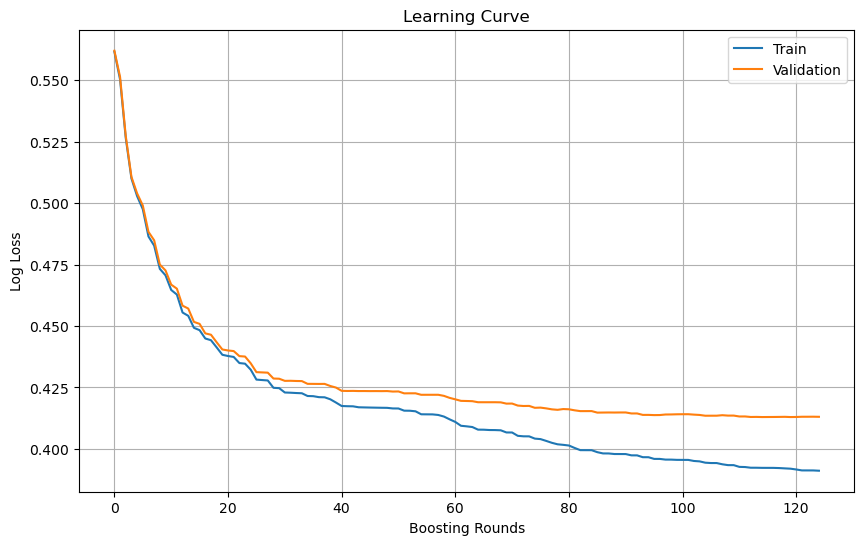

In [31]:
# Get the best parameters from the Optuna study
best_params = {'lambda': 0.15, 'alpha': 0, 'eta': 0.16, 'max_depth': 5, 
               'min_child_weight': 8.0, 'gamma': 0.066, 'grow_policy': 'depthwise', 
               'subsample': 0.978, 'colsample_bytree': 0.928}


# Perform train-validation split
game_ids = data_train.game_id.unique()
game_ids_train, game_ids_valid = train_test_split(game_ids, test_size=0.2, random_state=42)

train_x = data_train[data_train.game_id.isin(game_ids_train)].drop(columns='game_id')
valid_x = data_train[data_train.game_id.isin(game_ids_valid)].drop(columns='game_id')
train_y = target_train[target_train.index.isin(train_x.index)].values.ravel()
valid_y = target_train[target_train.index.isin(valid_x.index)].values.ravel()

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

feature_names = train_x.columns.tolist()
monotonic_constraints_map = {
    "fg_distance": -1,
    "wind_speed": -1,
    "elevation": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "game_indoors": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])
  
best_params.update({
    "objective": "binary:logistic",
    "nthread": -1,
    "interaction_constraints": [["score_diff", "pct_game_played"]],
    "monotone_constraints": monotonic_constraints,
    "booster": "gbtree",
})

# Train the model with early stopping
evals_result = {}
model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, "train"), (dvalid, "eval")],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

preds = model.predict(dtrain)
logloss = log_loss(train_y, preds)
print(f"Training Log Loss: {logloss}")
preds = model.predict(dvalid)
logloss = log_loss(valid_y, preds)
print(f"Validation Log Loss: {logloss}")

# Plot the learning curve
def plot_learning_curve(evals_result):
    train_metric = evals_result["train"]["logloss"]
    eval_metric = evals_result["eval"]["logloss"]

    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label="Train")
    plt.plot(eval_metric, label="Validation")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("Log Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(evals_result)

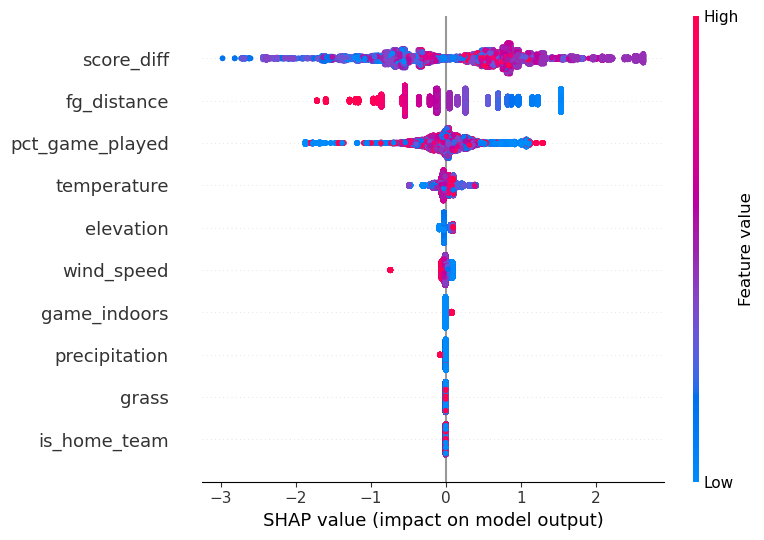

In [32]:
# SHAP values for feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

# Plot SHAP summary
shap.summary_plot(shap_values, train_x)

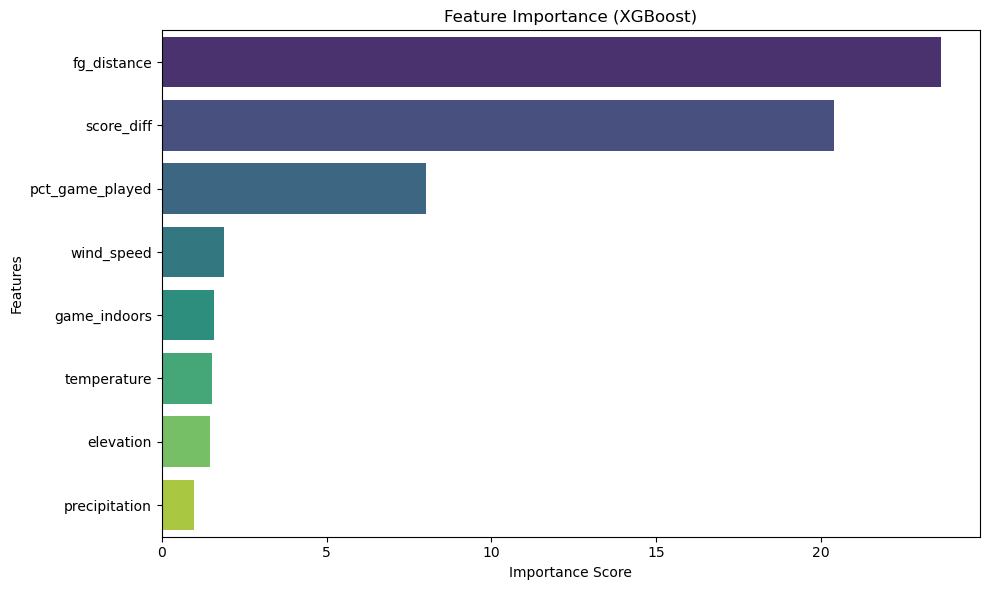

In [33]:
def plot_feature_importance(model):
    # Get feature importance scores
    importance = model.get_score(importance_type="gain")  # weight, gain, cover
    
    # Convert to a DataFrame for easier plotting
    importance_df = pd.DataFrame({
        "Feature": list(importance.keys()),
        "Importance": list(importance.values())
    }).sort_values(by="Importance", ascending=False)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis",  # Custom color palette
        hue="Feature",      # Assign `Feature` to `hue`
        dodge=False         # Avoid splitting bars
    )
    plt.title("Feature Importance (XGBoost)")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)  # Remove the legend
    plt.tight_layout()
    plt.show()

# Call the function
plot_feature_importance(model)

In [36]:
dtest = xgb.DMatrix(data_test)
preds = model.predict(dtest)
logloss = log_loss(target_test.values.ravel(), preds)
print(f"Test Log Loss: {logloss}")

Test Log Loss: 0.40782634702278947


In [37]:
#make predictions on complete dataset
data_all = data.drop(columns='game_id')
dall = xgb.DMatrix(data_all)
preds_all = model.predict(dall)
df['fg_proba'] = preds_all

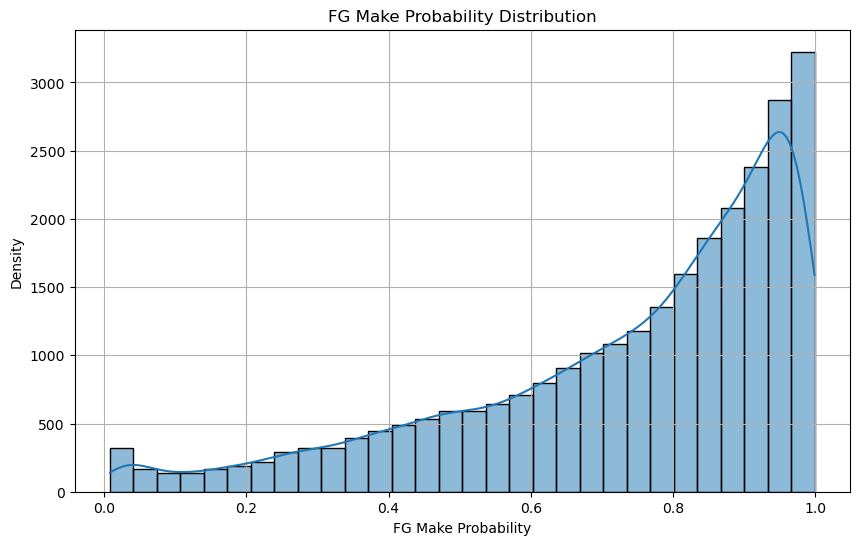

In [38]:
# plot win probability
def plot_wp(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['fg_proba'], bins=30, kde=True)
    plt.title('FG Make Probability Distribution')
    plt.xlabel('FG Make Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df)

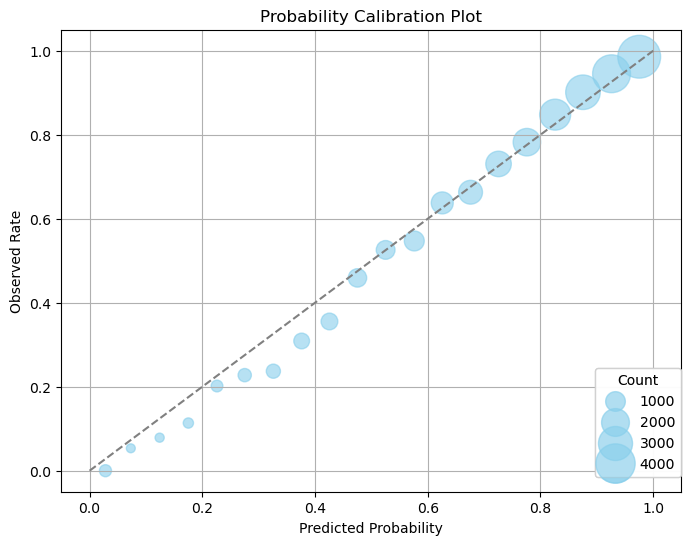

In [39]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='fg_proba', actual_col='fg_made', bins=20)

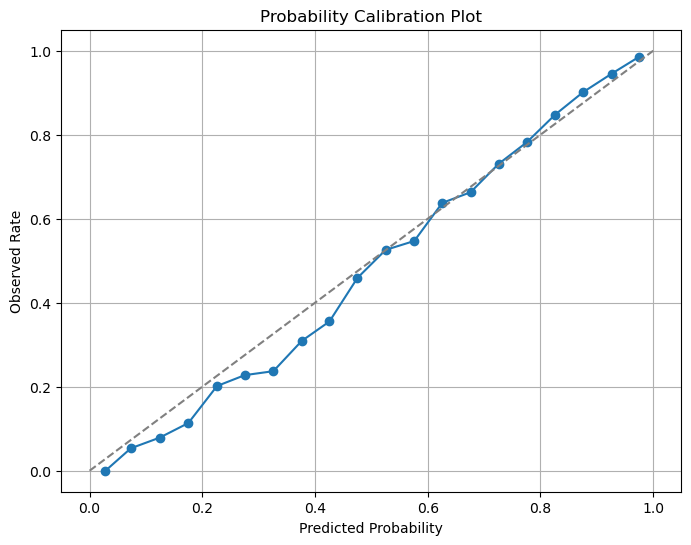

In [40]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='fg_proba', actual_col='fg_made', bins=20)